## Build STAC catalog of RETREAT data

RETREAT ice velocity data generated from S1 image pairs

paper - https://essd.copernicus.org/articles/13/4653/2021/essd-13-4653-2021-discussion.html
SI - https://essd.copernicus.org/articles/13/4653/2021/essd-13-4653-2021-supplement.pdf
file download info: {insert filelist_velocitiesXXXX.txt}
data downloaded from: https://retreat.geographie.uni-erlangen.de


Used this [tutorial/example](https://towardsdatascience.com/organizing-geospatial-data-with-spatio-temporal-assets-catalogs-stac-using-python-45f1a64ca082) heavily while organizing this data as a STAC catalog.

In [1]:
from pathlib import Path
import numpy as np
import stackstac
import xarray as xr
import glob
import shutil
import pystac
from itertools import groupby
from shapely.geometry import Polygon, mapping
import rasterio as rio
import os
import pandas as pd
import rasterio as rio
from rasterio.warp import transform_bounds, transform_geom
from pystac.extensions import item_assets 
from pystac.extensions.projection import AssetProjectionExtension
import pandas as pd
from rasterio.warp import transform_bounds, transform_geom
import matplotlib.pyplot as plt

In [2]:
def parse_fname(fposix):
    '''extract relevant metadata from filename and return it as variables that will be used when creating stac items
    note function takes `pathlib.PosixPath` objects, not strs
    '''
    fname = fposix.stem
    prevar = fname.split('-')[0]
    var = fname.split('-')[1].split('+')[0]
    post_var = fname.split('-')[1].split('+')[1]
    
    sensor = post_var[:2]
    #tried formating acq,sec date as datetime at first but catalog won't save if property objects are datetimes, it seems 
    
    temp = post_var.split('S1_')
    acq_date = temp[1].split('_')[0]
    acq_id = temp[1].split('_')[1]
    sec_date = temp[2].split('_')[0]
    sec_id = temp[2].split('_')[1]
    
    site = prevar[:2]
    frame = prevar[3:6]
    orbit = prevar[7:10]
    mid_date = pd.to_datetime(prevar[11:19])
    
   
    
    return sensor, acq_date, acq_id, sec_date, sec_id, site, orbit, frame, mid_date

In [3]:
def get_bbox_and_footprint(dataset):

    # create the bounding box it will depend if it comes from rasterio or rioxarray
    bounds = dataset.bounds

    if isinstance(bounds, rio.coords.BoundingBox):
        bbox = (bounds.left, bounds.bottom, bounds.right, bounds.top)
    else:
        bbox = (float(f) for f in bounds())

    # create the footprint
    footprint = Polygon([
        [bbox[0], bbox[1]],
        [bbox[0], bbox[3]],
        [bbox[2], bbox[3]],
        [bbox[2], bbox[1]]
    ])

    return bbox, mapping(footprint)

    return bbox, mapping(footprint)

In [4]:
#Create catalog
catalog = pystac.Catalog(
    id = 'RETREAT data, Langtang',
    description = 'RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet',
    stac_extensions = ['https://stac-extensions.github.io/projection/v1.0.0/schema.json']
)

In [5]:
#set path to data
folder = Path('/home/emmamarshall/Desktop/phd_work/retreat/data/')
folder

PosixPath('/home/emmamarshall/Desktop/phd_work/retreat/data')

In [8]:
#type(dis_angs[0])

In [9]:
#ds = xr.open_dataset(dis_angs[0], engine='rasterio').squeeze()

In [33]:
ds_rasterio = rio.open(dis_angs[0])

In [35]:
ds_rasterio.crs.to_epsg()

32645

In [6]:
#create filepath lists for each variable
dis_angs = list(folder.rglob('*dis_angle*.tif'))
dis_azs = list(folder.rglob('*dis_az*.tif'))
dis_mags = list(folder.rglob('*dis_mag*.tif'))
dis_N_angs = list(folder.rglob('*dis_N_ang*.tif'))
dis_rs = list(folder.rglob('*dis_r*.tif'))

In [7]:
def build_stac_catalog(dis_angs, dis_azs, dis_mags, dis_N_angs, dis_rs):
    
    #make list of all vars
    var_ls = [dis_angs, dis_azs, dis_mags, dis_N_angs, dis_rs]
    #ensure that the lists of vars are correctly ordered, ie calling same acquisition across vars
    zero_element = [var_ls[var][0].stem[:19] for var in range(len(var_ls))]

    if len(set(zero_element)) > 1:
        print('there is a file issue here')
    else:
        pass


    for file in range(len(dis_angs)):

        sensor, acq_date, acq_id, sec_date, sec_id, site, orbit, frame, mid_date = parse_fname(dis_angs[file])

        #ds_xr = xr.open_dataset(dis_angs[file], engine='rasterio')
        
        ds = rio.open(dis_angs[file])
        bbox, footprint = get_bbox_and_footprint(ds)
        
        #affine_transform = ds.transform
        
        
        #shape = [len(ds.x.data), len(ds.y.data)]

        #left = ds.x.data.min()
        #right = ds.x.data.max()
        #bottom = ds.y.data.min()
        #top = ds.y.data.max()

        #bbox = [left, bottom, right, top]
        #footprint = mapping(Polygon([
        #        [bbox[0], bbox[1]],
        #        [bbox[0], bbox[3]],
        #        [bbox[2], bbox[3]],
        #        [bbox[2], bbox[1]]
        #        ]))
        #bbox, footprint = get_bbox_and_footprint(ds)


        geo_bounds = transform_bounds(ds.crs, 'EPSG:4326', *bbox)
        geo_footprint = transform_geom(ds.crs, 'EPSG:4326', footprint)

        idx = dis_angs[file].stem[:19]
        #print(idx)
        #date = pd.to_datetime(dis_ang.stem[11:19])
        date = dis_angs[file].stem[11:19]
        tile = idx[:10]
        #print(tile)

        #make assets for each time step (each geotiff file)
        dis_ang_asset = pystac.Asset(
                href = dis_angs[file].as_posix(),
                media_type=pystac.MediaType.GEOTIFF,
                title = str(dis_angs[file].stem.split('-')[1].split('+')[0]),
            )
        dis_az_asset = pystac.Asset(
            href = dis_azs[file].as_posix(),
            media_type = pystac.MediaType.GEOTIFF,
            title = str(dis_azs[file].stem.split('-')[1].split('+')[0]),
        )
        dis_mag_asset = pystac.Asset(
            href = dis_mags[file].as_posix(),
            media_type = pystac.MediaType.GEOTIFF,
            title = str(dis_mags[file].stem.split('-')[1].split('+')[0]),
        )
        dis_N_ang_asset = pystac.Asset(
            href = dis_N_angs[file].as_posix(),
            media_type = pystac.MediaType.GEOTIFF,
            title = str(dis_N_angs[file].stem.split('-')[1].split('+')[0]),
        )
        dis_r_asset = pystac.Asset(
            href = dis_rs[file].as_posix(),
            media_type = pystac.MediaType.GEOTIFF,
            title = str(dis_rs[file].stem.split('-')[1].split('+')[0]),
        )
      
        #make item (1 item per timestep/siet)
        item = pystac.Item(
            id = idx,
            geometry= geo_footprint,
            bbox= geo_bounds,
            datetime= pd.to_datetime(date),
            stac_extensions=['https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
            assets = {'dis_ang':dis_ang_asset,
                      'dis_az':dis_az_asset,
                      'dis_mag':dis_mag_asset,
                      'dis_N_ang':dis_N_ang_asset,
                      'dis_r':dis_r_asset},
            properties = dict(
                sensor = sensor,
                acq_date = acq_date,
                sec_date = sec_date,
                acq_id = acq_id,
                sec_id = sec_id,
                frame = frame, 
                orbit = orbit,
                site = site,
                )
        )
        #extend asset wtih projection extension
        asset_ext = AssetProjectionExtension.ext(item.assets['dis_ang'])
        asset_ext.epsg = ds.crs.to_epsg()
        asset_ext.shape = ds.shape
        asset_ext.bbox = bbox
        asset_ext.geometry = footprint
        #asset_ext.transform = ds.spatial_ref.attrs['GeoTransform']
        asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']
    
        asset_ext = AssetProjectionExtension.ext(item.assets['dis_az'])
        asset_ext.epsg = ds.crs.to_epsg()
        asset_ext.shape = ds.shape
        asset_ext.bbox = bbox
        asset_ext.geometry = footprint
        #asset_ext.transform = ds.spatial_ref.attrs['GeoTransform']
        asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']

        asset_ext = AssetProjectionExtension.ext(item.assets['dis_mag'])
        asset_ext.epsg = ds.crs.to_epsg()
        asset_ext.shape = ds.shape
        asset_ext.bbox = bbox
        asset_ext.geometry = footprint
        #asset_ext.transform = ds.spatial_ref.attrs['GeoTransform']
        asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']

    
        asset_ext = AssetProjectionExtension.ext(item.assets['dis_N_ang'])
        asset_ext.epsg = ds.crs.to_epsg()
        asset_ext.shape = ds.shape
        asset_ext.bbox = bbox
        asset_ext.geometry = footprint
        #asset_ext.transform = ds.spatial_ref.attrs['GeoTransform']
        asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']

    
        asset_ext = AssetProjectionExtension.ext(item.assets['dis_r'])
        asset_ext.epsg = ds.crs.to_epsg()
        asset_ext.shape = ds.shape
        asset_ext.bbox = bbox
        asset_ext.geometry = footprint
        #asset_ext.transform = ds.spatial_ref.attrs['GeoTransform']
        asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']

    
        catalog.add_item(item)

    
            

In [8]:
build_stac_catalog(dis_angs, dis_azs, dis_mags, dis_N_angs, dis_rs)

In [9]:
print(len(list(catalog.get_all_items())))

314


In [10]:
!pwd

/home/emmamarshall/Desktop/phd_work/retreat/retreat/code


In [11]:
catalog.normalize_hrefs('/home/emmamarshall/Desktop/phd_work/retreat/stac_catalog')

In [12]:
catalog.save()

In [61]:
#from pystac import (Catalog, Item, CatalogType)

#catalog.normalize_and_save('/home/emmamarshall/Desktop/phd_work/retreat/retreat/code/new_stac_catalog', catalog_type=CatalogType.SELF_CONTAINED)

In [13]:
catalog

"ID: RETREAT data, Langtang"
Description: RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: (83.90330006691758, 27.315628829239383, 86.84789887313025, 29.395858032270436)"
Datetime: 2021-01-13 00:00:00
sensor: S1
acq_date: 20210107T122220
sec_date: 20210119T122219
acq_id: BFF8
sec_id: DDCD


## Testing
compare the catalog when read from file to the one in memory

In [14]:
import json

cat_new = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/stac_catalog/catalog.json')
items_new = list(cat_new.get_items())

In [15]:
items_new[0]

ID: 10_085_053_20210113
"Bounding Box: [83.90330006691758, 27.315628829239383, 86.84789887313025, 29.395858032270436]"
Datetime: 2021-01-13 00:00:00+00:00
sensor: S1
acq_date: 20210107T122220
sec_date: 20210119T122219
acq_id: BFF8
sec_id: DDCD
frame: 085
orbit: 053
site: 10


In [16]:
cube_read = stackstac.stack(
    items = [item.to_dict() for item in items_new],
    epsg = '32645')
   

In [21]:
cube_read.sel(band='dis_mag').isel(time=1).min().compute()

CRSError: The WKT could not be parsed. OGR Error code 5

## Organizing for analysis... 
moving ahead with workflow with the `catalog` object created in notebook, not read from file

In [22]:
items_local = list(catalog.get_items())

In [23]:
len(items_local)

314

In [24]:
cube_local = stackstac.stack(
    items = [item.to_dict() for item in items_local])
  

In [25]:
cube_local

<xarray.DataArray 'stackstac-0a438beb2afd469d296ba54cf129d33d' (time: 314,
                                                                band: 5,
                                                                y: 1951, x: 1875)>
dask.array<fetch_raster_window, shape=(314, 5, 1951, 1875), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time       (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id         (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * band       (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x          (x) float64 1.128e+05 1.13e+05 1.132e+05 ... 4.874e+05 4.876e+05
  * y          (y) float64 3.357e+06 3.357e+06 3.357e+06 ... 2.967e+06 2.967e+06
    frame      (time) <U3 '085' '019' '019' '085' ... '019' '019' '019' '019'
    ...         ...
    orbit      (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    sensor     <U2 'S1'
    sec_date   (time) <U15 '20141104T122155' ... '20211111T001930'
    proj:epsg  int64 32645
    title      (band) <U9 'dis_angle' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg       int64 32645
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    crs:         epsg:32645
    transform:   | 200.00, 0.00, 112800.00|\n| 0.00,-200.00, 3357000.00|\n| 0...
    resolution:  200.0

In [26]:
cube_local.isel(time=1).sel(band='dis_mag').mean(dim=['x','y']).compute()

<xarray.DataArray 'stackstac-0a438beb2afd469d296ba54cf129d33d' ()>
array(0.13113698)
Coordinates: (12/14)
    time       datetime64[ns] 2014-10-31
    id         <U19 '10_019_001_20141031'
    band       <U9 'dis_mag'
    frame      <U3 '019'
    site       <U2 '10'
    sec_id     <U4 '1CFB'
    ...         ...
    orbit      <U3 '001'
    sensor     <U2 'S1'
    sec_date   <U15 '20141112T001854'
    proj:epsg  int64 32645
    title      <U9 'dis_mag'
    epsg       int64 32645

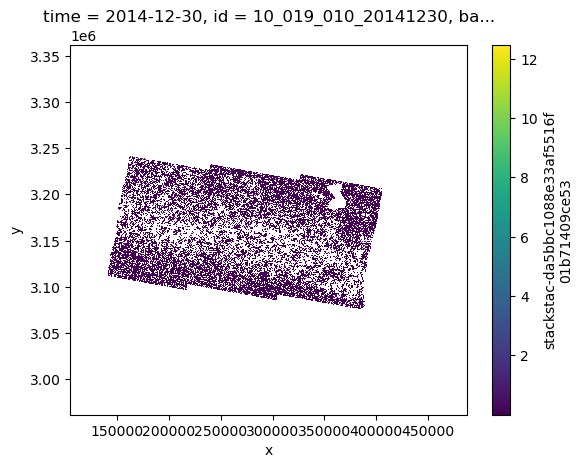

In [23]:
#cube_local.isel(time=10).sel(band='dis_mag').plot()

## RETREAT work

can't figure out why reading the catalog from file doesn't work so going to start the workflow in the same notebook that the catalog is built in 

## Other data

### NASADEM

In [27]:
nasadem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/NASADEM_NC_n28e085.nc').squeeze()

In [28]:
nasadem = nasadem.rio.write_crs('EPSG:4326')

In [29]:
nasadem_prj = nasadem.rio.reproject('EPSG:32645')

### RGI

In [30]:
import geopandas as gpd
rgi_path = '/home/emmamarshall/Desktop/data/rgi/south_asia_east_15/'
rgi15 = gpd.read_file(os.path.join(rgi_path,'15_rgi60_SouthAsiaEast.shp'))
rgi15_prj = rgi15.to_crs('EPSG:32645')

In [31]:
rgi_ids = pd.read_csv('/home/emmamarshall/Desktop/phd_work/retreat/manuscript_edits/manuscript_rgi_ids.csv', )

In [32]:
lake_ids = ['RGI60-15.10255', 'RGI60-15.10285', 'RGI60-15.10279','RGI60-15.10286',
            'RGI60-15.09361','RGI60-15.09483','RGI60-15.10290','RGI60-15.10299']

In [33]:
rgi_ids.head()

,RGI_IDs
0,RGI60-15.10255
1,RGI60-15.10285
2,RGI60-15.10279
3,RGI60-15.10286
4,RGI60-15.03976


In [34]:
rgi_subset = rgi15_prj.loc[rgi15_prj['RGIId'].isin(rgi_ids['RGI_IDs'])]

In [35]:
rgi_lakes = rgi_subset.loc[rgi_subset['RGIId'].isin(lake_ids)]

In [36]:
rgi_lands = rgi_subset.loc[~rgi_subset['RGIId'].isin(lake_ids)]

In [37]:
land_ids = rgi_lands['RGIId'].to_list()

## Ind glacier workflow to start

In [38]:
def clip_glacier_add_dem(rgi_id, rgi_full, retreat_xr, nasadem ): #all should be in local utm
    
    rgi_single = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    
    retreat_clip = retreat_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    dem_clip = nasadem.rio.clip(rgi_single.geometry, rgi_single.crs)
    
    dem_downsamp = dem_clip.interp_like(retreat_clip, method = 'nearest')
    
    retreat_clip['z'] = (('y','x'), dem_downsamp.NASADEM_HGT.data)
    
    retreat_clip_ds = retreat_clip.to_dataset(dim='band')
    
    retreat_clip_ds = retreat_clip_ds.drop_dims('band')
    
    retreat_clip_ds['dis_mag_my'] = retreat_clip_ds['dis_mag'] * 365
    
    med_z = float(np.nanmedian(retreat_clip_ds.z.data))
    
    ablation_clip = retreat_clip_ds.where(retreat_clip_ds.z <= med_z)

    
    return ablation_clip

In [39]:
def clip_by_median_z(glacier_xr_obj):
    
    #calc med z for the glacier
    med_z = float(np.nanmedian(glacier_xr_obj.z.data))
    
    ablation_clip = glacier_xr_obj.where(glacier_xr_obj.z <= med_z)
    
    return ablation_clip

In [40]:
def subset_by_season(full_xr, season): # this is diff than gb 
    
    #need to reformat obj
    acq_date = pd.DatetimeIndex(full_xr['acq_date'].values)
    sec_date = pd.DatetimeIndex(full_xr['sec_date'].values)
    
    full_xr = full_xr.drop('acq_date')
    full_xr = full_xr.drop('sec_date')
    
    full_xr.coords['acq_date'] = ('time',acq_date)
    full_xr.coords['sec_date'] = ('time', sec_date)
    
    season_obj = full_xr.where((full_xr.acq_date.dt.season == season) & (full_xr.sec_date.dt.season == season))
    season_obj_coord = season_obj.assign_coords(season=season)
    season_obj_coord = season_obj_coord.expand_dims('season')
    
    return season_obj_coord
    

In [41]:
def add_seasonal_change_vars(input_xr):
    
    input_xr['winter_minus_fall'] = (input_xr.sel(season = 'DJF').dis_mag_my.mean(dim='time')) - (input_xr.sel(season = 'SON').dis_mag_my.mean(dim='time'))
    input_xr['spring_minus_winter'] = (input_xr.sel(season = 'MAM').dis_mag_my.mean(dim='time')) - (input_xr.sel(season = 'DJF').dis_mag_my.mean(dim='time'))
    input_xr['summer_minus_spring'] = (input_xr.sel(season = 'JJA').dis_mag_my.mean(dim='time')) - (input_xr.sel(season = 'MAM').dis_mag_my.mean(dim='time'))
    input_xr['fall_minus_summer'] = (input_xr.sel(season = 'SON').dis_mag_my.mean(dim='time')) - (input_xr.sel(season = 'JJA').dis_mag_my.mean(dim='time'))
    
    return input_xr
    

In [42]:
def calc_seasonal_change(seasonal_change_xr, rgi_id):
    
    winter = float(seasonal_change_xr.sel(season='DJF').dis_mag_my.mean(dim=['time','x','y']).compute().data)
    spring = float(seasonal_change_xr.sel(season='MAM').dis_mag_my.mean(dim=['time','x','y']).compute().data)
    summer = float(seasonal_change_xr.sel(season='JJA').dis_mag_my.mean(dim=['time','x','y']).compute().data)
    fall = float(seasonal_change_xr.sel(season='SON').dis_mag_my.mean(dim=['time','x','y']).compute().data)

    winter_minus_fall = float(seasonal_change_xr.winter_minus_fall.mean().compute().data)
    spring_minus_winter = float(seasonal_change_xr.spring_minus_winter.mean().compute().data)
    summer_minus_spring = float(seasonal_change_xr.summer_minus_spring.mean().compute().data)
    fall_minus_summer = float(seasonal_change_xr.fall_minus_summer.mean().compute().data)
    
    d = {'RGIId': rgi_id, 'winter':winter, 'spring':spring, 'summer': summer, 'fall':fall,
         'winter_minus_fall':winter_minus_fall, 'spring_minus_winter':spring_minus_winter,
         'summer_minus_spring':summer_minus_spring, 'fall_minus_summer':fall_minus_summer}
    
    #df = pd.DataFrame(d)
    
    return d

In [43]:
def driver_fn(rgi_id, rgi_subset, retreat_obj, nasadem_prj):   #this should take a rgi id (dict key) and return the object that will be the dict value (i think a pd df)
    
    retreat_clip_obj = clip_glacier_add_dem(rgi_id, rgi_subset, retreat_obj, nasadem_prj)
    
    FALL = subset_by_season(retreat_clip_obj, 'SON')
    WINTER = subset_by_season(retreat_clip_obj, 'DJF')
    SPRING = subset_by_season(retreat_clip_obj, 'MAM')
    SUMMER = subset_by_season(retreat_clip_obj, 'JJA')
    
    seasons_gb = xr.combine_by_coords([FALL,WINTER,SPRING,SUMMER])
    
    seasonal_diffs = add_seasonal_change_vars(seasons_gb)
    
    d = calc_seasonal_change(seasonal_diffs, rgi_id)
    
    df = pd.DataFrame(d, index=[0])
    
    return df

In [44]:
len(lake_ids)-1

7

In [47]:
def create_dict_vals(rgi_ids, rgi_subset, retreat_obj, nasadem_prj, start_number = 0, end_number=len(rgi_ids)-1):   #this
    val_ls = []
    
    for element in range(len(rgi_ids))[start_number:end_number]:
        
        val = driver_fn(rgi_ids[element], rgi_subset, retreat_obj, nasadem_prj)
        
        val_ls.append(val)
        
    return val_ls
        

In [ ]:
lake_vals = create_dict_vals(lake_ids, rgi_lakes, cube_local, nasadem_prj)

In [ ]:
#merge all lake_vals dfs into onen

lakes_df = pd.concat(lake_vals)

In [ ]:
lakes_df

<AxesSubplot: ylabel='Frequency'>

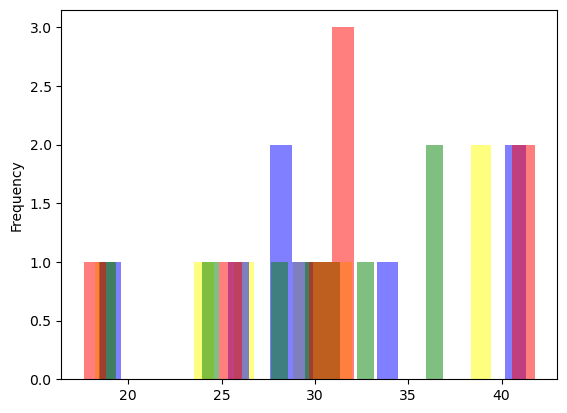

In [42]:
fig, ax = plt.subplots()

lakes_df['fall'].plot.hist(alpha = 0.5, ax=ax, bins = 20, color = 'yellow')
lakes_df['winter'].plot.hist(alpha=0.5, ax=ax, bins = 20, color = 'blue')
lakes_df['spring'].plot.hist(alpha=0.5, ax=ax, bins = 20, color = 'green')
lakes_df['summer'].plot.hist(alpha=0.5, ax=ax, bins = 20, color = 'red')


In [ ]:
land_vals = create_dict_vals(land_ids, rgi_lands, cube_local, nasadem_prj, 0,6)

In [62]:
lake_dict = dict(zip(lake_ids, lake_vals))

In [61]:
lake_ids[0]

'RGI60-15.10255'

In [60]:
lake_vals[0]

,RGIId,winter,spring,summer,fall,winter_minus_fall,spring_minus_winter,summer_minus_spring,fall_minus_summer
0,RGI60-15.10255,40.301103,36.857729,41.786283,38.800368,1.144366,-3.68906,6.126728,-3.582034


In [34]:
full_10255 = clip_glacier_add_dem('RGI60-15.10255', rgi_subset, cube_local, nasadem_prj)

In [64]:
#abl_10255 = clip_by_median_z(full_10255)

In [38]:
abl_10255_FALL = subset_by_season(full_10255, 'SON')
abl_10255_WINTER = subset_by_season(full_10255, 'DJF')
abl_10255_SPRING = subset_by_season(full_10255, 'MAM')
abl_10255_SUMMER = subset_by_season(full_10255, 'JJA')

In [39]:
abl_10255_gb = xr.combine_by_coords([abl_10255_WINTER, abl_10255_SPRING, abl_10255_SUMMER, abl_10255_FALL])
                                    

In [43]:
abl_10255_gb_diffs = add_seasonal_change_vars(abl_10255_gb)

In [47]:
d = calc_seasonal_change(abl_10255_gb_diffs, 'RGI60-15.10255')

In [50]:
df = pd.DataFrame(d, index=[0])

In [51]:
df

,RGIId,winter,spring,summer,fall,winter_minus_fall,spring_minus_winter,summer_minus_spring,fall_minus_summer
0,RGI60-15.10255,40.301103,36.857729,41.786283,38.800368,1.144366,-3.68906,6.126728,-3.582034


In [108]:
print(abl_10255_gb_diffs.winter_minus_fall.mean().compute().data)
print(abl_10255_gb_diffs.spring_minus_winter.mean().compute().data)
print(abl_10255_gb_diffs.summer_minus_spring.mean().compute().data)
print(abl_10255_gb_diffs.fall_minus_summer.mean().compute().data)


1.1443656555792807
-3.689060120436702
6.126728432730648
-3.5820339678732265


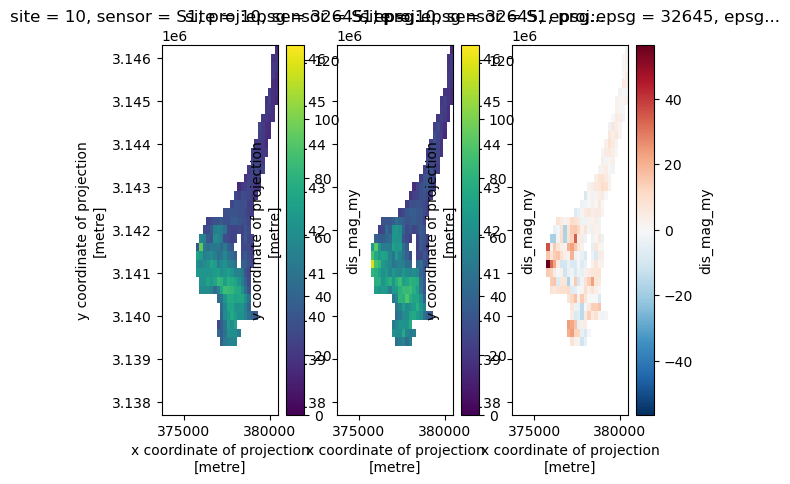

In [80]:
fig, axs = plt.subplots(ncols=3)
abl_10255_gb.sel(season='SON').dis_mag_my.mean(dim='time').plot(ax=axs[0], vmin=0, vmax= 125)
abl_10255_gb.sel(season='JJA').dis_mag_my.mean(dim='time').plot(ax=axs[1], vmin = 0, vmax=125)
(abl_10255_gb.sel(season='JJA').dis_mag_my.mean(dim='time')-abl_10255_gb.sel(season='SON').dis_mag_my.mean(dim='time')).plot(ax=axs[2])

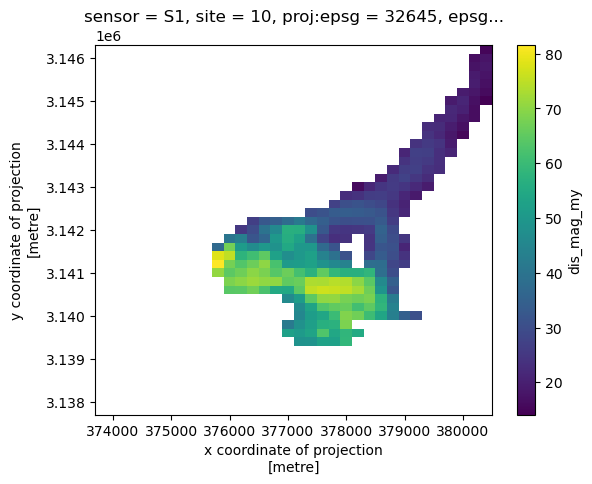

In [164]:
abl_10255.dis_mag_my.mean(dim='time').plot()

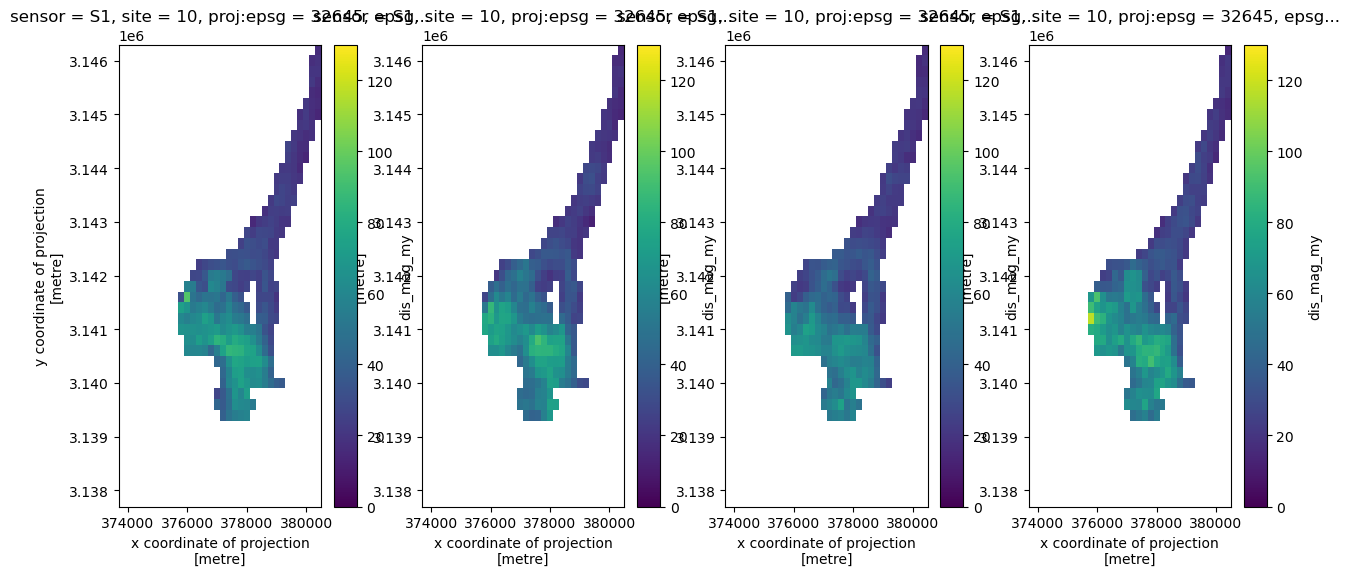

In [167]:
fig, axs = plt.subplots(ncols=4, figsize=(15,6))

abl_10255_FALL.dis_mag_my.mean(dim='time').plot(ax=axs[0], vmin=0, vmax= 130)
abl_10255_WINTER.dis_mag_my.mean(dim='time').plot(ax=axs[1], vmin=0, vmax= 130)
abl_10255_SPRING.dis_mag_my.mean(dim='time').plot(ax=axs[2], vmin=0, vmax= 130)
abl_10255_SUMMER.dis_mag_my.mean(dim='time').plot(ax=axs[3], vmin=0, vmax= 130)

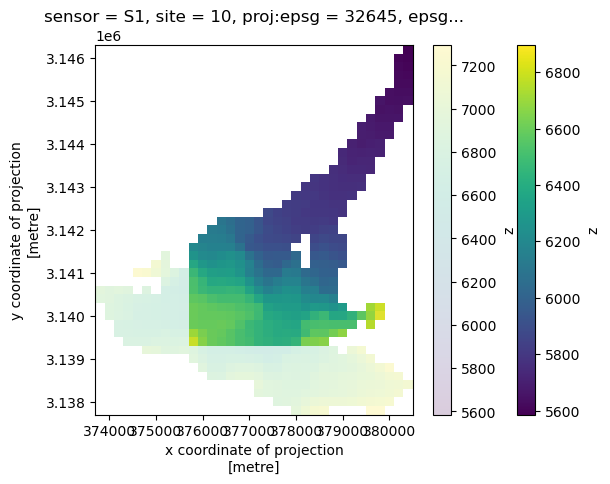

In [107]:
fig, ax = plt.subplots()
ablation_10255.z.plot(ax=ax)
full_10255.z.plot(ax=ax, alpha = 0.2)


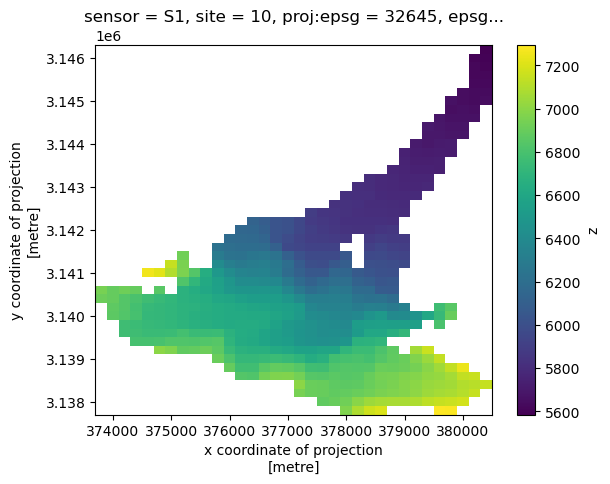

In [82]:
full_10255.z.plot()

In [35]:
rgi1 = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.03976']
rgi2 = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.04220']

In [36]:
retreat1 = cube_local.rio.clip(rgi1.geometry, rgi1.crs)

In [209]:
retreat1_ds = retreat1.to_dataset(dim='band')

In [210]:
retreat1_ds = retreat1_ds.drop_dims('band')

In [211]:
retreat1_ds

<xarray.Dataset>
Dimensions:      (time: 314, y: 19, x: 15)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 'D1BD' '1CFB' '3910' 'C64F' ... 'F61C' 'D582' '3830'
    sensor       <U2 'S1'
    ...           ...
    acq_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
    sec_date     (time) <U15 '20141104T122155' ... '20211111T001930'
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [212]:
acq_date1 = pd.DatetimeIndex(retreat1_ds['acq_date'].values)
sec_date1 = pd.DatetimeIndex(retreat1_ds['sec_date'].values)

In [213]:
acq_date1 = pd.DatetimeIndex(retreat1_ds['acq_date'].values)
sec_date1 = pd.DatetimeIndex(retreat1_ds['sec_date'].values)
retreat1_ds = retreat1_ds.drop('acq_date')
retreat1_ds = retreat1_ds.drop('sec_date')
retreat1_ds.coords['acq_date'] = ('time',acq_date1)
retreat1_ds.coords['sec_date'] = ('time', sec_date1)

In [215]:
retreat1_ds.coords['acq_date'] = ('time',acq_date1)
retreat1_ds.coords['sec_date'] = ('time', sec_date1)

In [238]:
retreat1_FALL = retreat1_ds.where((retreat1_ds.acq_date.dt.season == 'SON') & (retreat1_ds.sec_date.dt.season == 'SON'), drop=True)
retreat1_WINTER = retreat1_ds.where((retreat1_ds.acq_date.dt.season == 'DJF') & (retreat1_ds.sec_date.dt.season == 'DJF'), drop=True)
retreat1_SPRING = retreat1_ds.where((retreat1_ds.acq_date.dt.season == 'MAM') & (retreat1_ds.sec_date.dt.season == 'MAM'), drop=True)
retreat1_SUMMER = retreat1_ds.where((retreat1_ds.acq_date.dt.season == 'JJA') & (retreat1_ds.sec_date.dt.season == 'JJA'), drop=True)

In [239]:
retreat1_FALL

<xarray.Dataset>
Dimensions:      (time: 62, y: 19, x: 15)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 'D1BD' '1CFB' '3910' 'C64F' ... 'E0E4' 'D582' '3830'
    sensor       <U2 'S1'
    ...           ...
    orbit        (time) <U3 '002' '001' '010' '002' ... '038' '045' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    acq_date     (time) datetime64[ns] 2014-10-11T12:21:55 ... 2021-10-30T00:...
    sec_date     (time) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11T00:...
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [240]:
retreat1_WINTER

<xarray.Dataset>
Dimensions:      (time: 64, y: 19, x: 15)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2014-12-22 2014-12-30 ... 2021-02-14
    id           (time) <U19 '10_085_005_20141222' ... '10_019_085_20210214'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 '2D12' '5BFB' 'B904' 'D084' ... 'C44D' '6F42' 'BDD5'
    sensor       <U2 'S1'
    ...           ...
    orbit        (time) <U3 '005' '001' '010' '005' ... '053' '085' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    acq_date     (time) datetime64[ns] 2014-12-10T12:21:50 ... 2021-02-08T00:...
    sec_date     (time) datetime64[ns] 2015-01-03T12:21:50 ... 2021-02-20T00:...
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [242]:
retreat1_SPRING

<xarray.Dataset>
Dimensions:      (time: 67, y: 19, x: 15)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2015-03-16 2015-03-24 ... 2021-05-21
    id           (time) <U19 '10_085_005_20150316' ... '10_019_085_20210521'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 'DA4B' '9E7B' '460B' '5FC5' ... 'B50F' 'B113' '5323'
    sensor       <U2 'S1'
    ...           ...
    orbit        (time) <U3 '005' '010' '001' '005' ... '085' '085' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    acq_date     (time) datetime64[ns] 2015-03-04T12:21:49 ... 2021-05-15T00:...
    sec_date     (time) datetime64[ns] 2015-03-28T12:21:49 ... 2021-05-27T00:...
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [243]:
retreat1_SUMMER

<xarray.Dataset>
Dimensions:      (time: 60, y: 19, x: 15)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2015-06-14 2015-06-16 ... 2021-07-20
    id           (time) <U19 '10_085_017_20150614' ... '10_019_085_20210720'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 '1B59' '9CDB' '4A99' '20E5' ... 'AC3F' 'C779' 'F61C'
    sensor       <U2 'S1'
    ...           ...
    orbit        (time) <U3 '017' '019' '017' '017' ... '085' '085' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
    acq_date     (time) datetime64[ns] 2015-06-08T12:21:45 ... 2021-07-14T00:...
    sec_date     (time) datetime64[ns] 2015-06-20T12:21:45 ... 2021-07-26T00:...
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

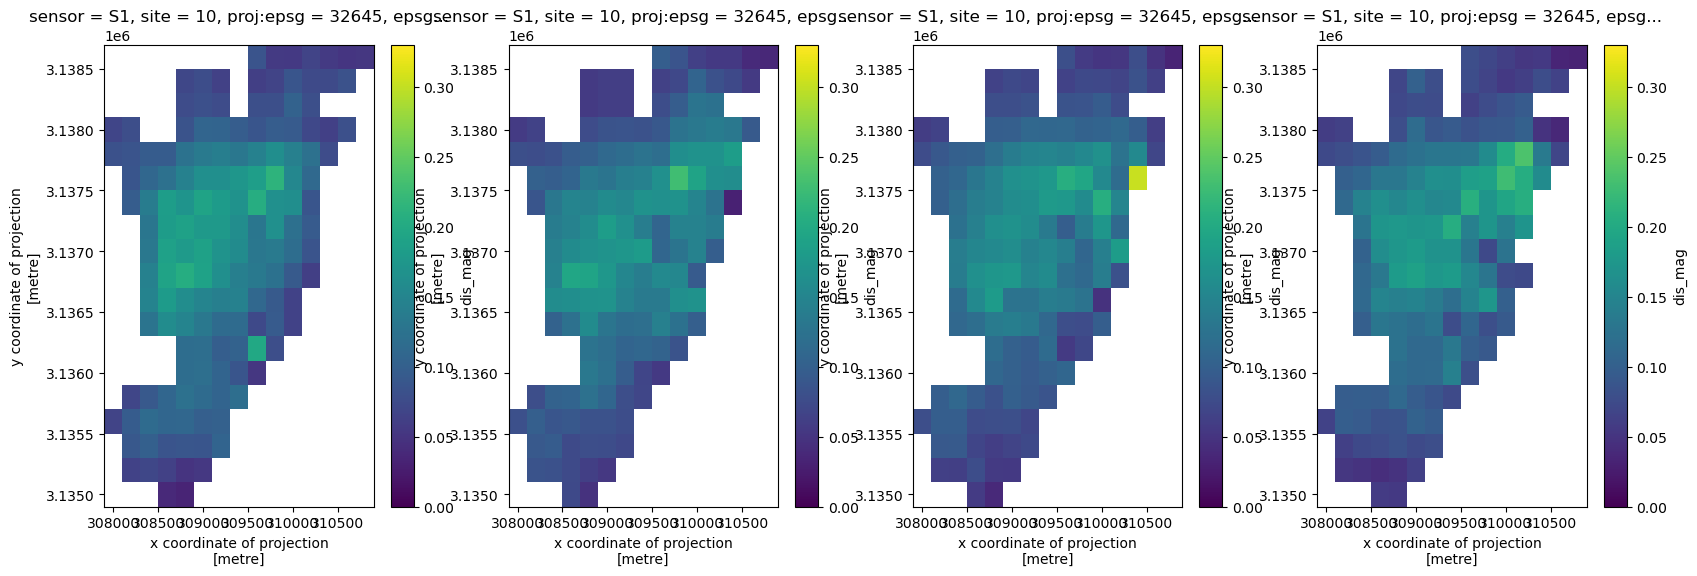

In [246]:
fig, axs = plt.subplots(figsize=(20,6), ncols =4)

retreat1_FALL.dis_mag.mean(dim='time').plot(ax=axs[0], vmin = 0, vmax=0.33)
retreat1_WINTER.dis_mag.mean(dim='time').plot(ax=axs[1], vmin = 0, vmax = 0.33)
retreat1_SPRING.dis_mag.mean(dim='time').plot(ax=axs[2], vmin = 0, vmax=0.33)
retreat1_SUMMER.dis_mag.mean(dim='time').plot(ax=axs[3], vmin = 0, vmax=0.33)

Selecting on season of the non dim coords (acq_date and sec_date) doesn't seem to be working. I think bc they are strings ? let's try switching to coded integers? 

In [165]:
#retreat1_ds.coords['acq_date'] = ('acq_date', pd.DatetimeIndex(retreat1_ds['acq_date'].values))
#retreat1_ds.coords['sec_date'] = ('sec_date', pd.DatetimeIndex(retreat1_ds['sec_date'].values))

In [163]:
#retreat1_ds = retreat1_ds.drop_dims('acq_date')
#retreat1_ds = retreat1_ds.drop_dims('sec_date')

In [164]:
retreat1_ds

<xarray.Dataset>
Dimensions:      (time: 314, y: 19, x: 15, acq_date: 314, sec_date: 314)
Coordinates: (12/15)
  * time         (time) datetime64[ns] 2014-10-23 2014-10-31 ... 2021-11-05
    id           (time) <U19 '10_085_002_20141023' ... '10_019_085_20211105'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
    sec_id       (time) <U4 'D1BD' '1CFB' '3910' 'C64F' ... 'F61C' 'D582' '3830'
    sensor       <U2 'S1'
    ...           ...
    acq_id       (time) <U4 '8496' 'C51B' 'C035' 'D1BD' ... 'C779' 'D64B' '85AD'
  * sec_date     (sec_date) datetime64[ns] 2014-11-04T12:21:55 ... 2021-11-11...
    orbit        (time) <U3 '002' '001' '010' '002' ... '085' '085' '085' '085'
    proj:epsg    int64 32645
    epsg         int64 32645
    spatial_ref  int64 0
Data variables:
    dis_ang      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_az       (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_mag      (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_N_ang    (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
    dis_r        (time, y, x) float64 dask.array<chunksize=(1, 19, 15), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [84]:
retreat2 = cube_local.rio.clip(rgi2.geometry, rgi2.crs)

In [86]:
retreat1_gb = retreat1.groupby(retreat1.time.dt.season).mean().reindex({'season':['DJF','MAM','JJA','SON']})

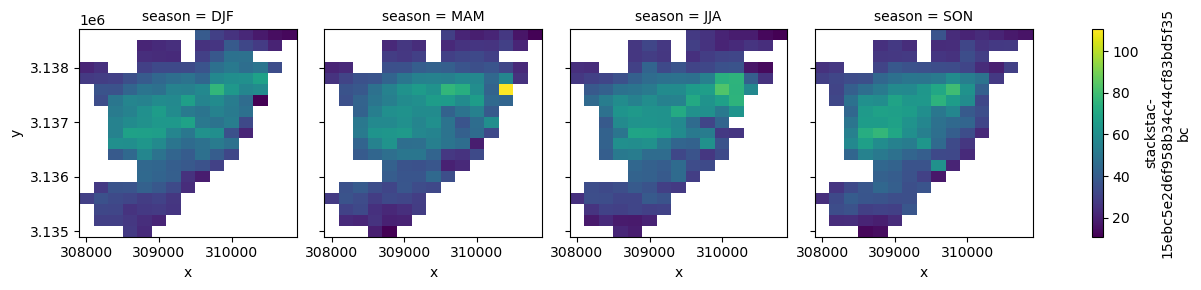

In [87]:
retreat1_fg = (retreat1_gb.sel(band='dis_mag')*365).plot(
    col='season',);

In [101]:
retreat1_gb

<xarray.DataArray 'stackstac-15ebc5e2d6f958b34c44cf83bd5f35bc' (season: 4,
                                                                band: 5, y: 19,
                                                                x: 15)>
dask.array<getitem, shape=(4, 5, 19, 15), dtype=float64, chunksize=(1, 1, 19, 15), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U9 'dis_ang' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
  * x            (x) float64 3.08e+05 3.082e+05 ... 3.106e+05 3.108e+05
  * y            (y) float64 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
  * season       (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
    sensor       <U2 'S1'
    site         <U2 '10'
    proj:epsg    int64 32645
    title        (band) <U9 'dis_angle' 'dis_az' 'dis_mag' 'dis_N_ang' 'dis_r'
    epsg         int64 32645
    spatial_ref  int64 0
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(112800.0, 2966800.0, 487800.0...
    resolution:  200.0

In [102]:
winter_minus_fall, spring_minus_winter, summer_minus_spring =  retreat1_gb.sel(band='dis_mag').diff(dim='season').compute()

Text(0.5, 1.0, 'summer minus spring')

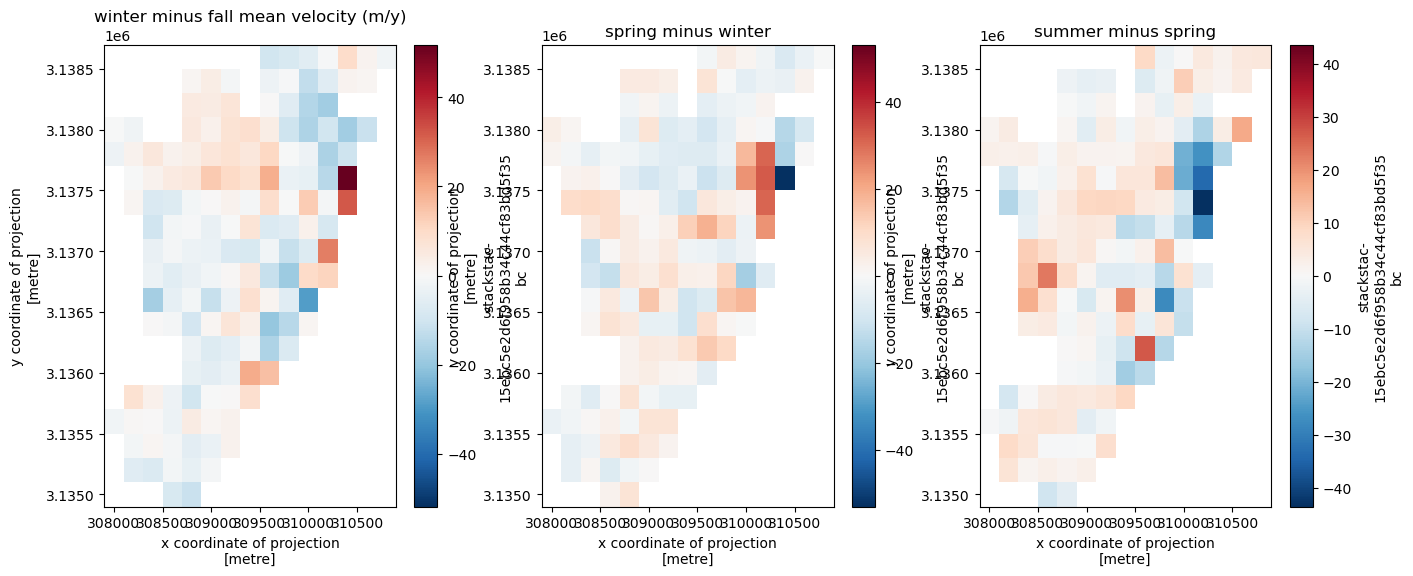

In [111]:
fig, axs = plt.subplots(ncols=3, figsize=(16,6))
(winter_minus_fall*365).plot(ax=axs[0])
axs[0].set_title('winter minus fall mean velocity (m/y)')

(spring_minus_winter*365).plot(ax=axs[1])
axs[1].set_title('spring minus winter')

(summer_minus_spring*365).plot(ax=axs[2])
axs[2].set_title('summer minus spring')

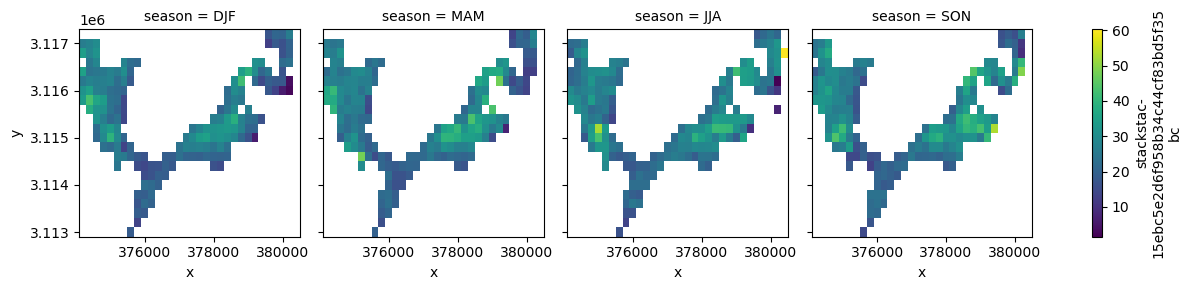

In [88]:
retreat2_gb = retreat2.groupby(retreat2.time.dt.season).mean().reindex({'season':['DJF','MAM','JJA','SON']})
retreat2_fg = (retreat2_gb.sel(band='dis_mag')*365).plot(
    col='season',);

## scale up to all glaciers

In [90]:
rgi_ids = rgi_subset['RGIId'].to_list()

In [ ]:
def clip_glacier_and_groupby(rgi_id, rgi_full, full_xr):
    
    rgi_single = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    
    single_glacier = full_xr.rio.clip(rgi_single.geometry, rgi_single.crs)
    

## Testing 

In [23]:
import json

cat_new = pystac.Catalog.from_file('/home/emmamarshall/Desktop/phd_work/retreat/stac_catalog/catalog.json')
items_new = list(cat_new.get_items())

In [24]:
cat_new

"ID: RETREAT data, Langtang"
Description: RETREAT velocity data for glaciers in Langtang region of Nepal/Tibet
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
ID: 10_085_053_20210113
"Bounding Box: [83.90330006691758, 27.315628829239383, 86.84789887313025, 29.395858032270436]"
Datetime: 2021-01-13 00:00:00+00:00
sensor: S1
acq_date: 20210107T122220
sec_date: 20210119T122219
acq_id: BFF8


In [30]:
#read in all items
#items_new = [item for item in cat_new.get_items()]

In [25]:
items_new[0]

ID: 10_085_053_20210113
"Bounding Box: [83.90330006691758, 27.315628829239383, 86.84789887313025, 29.395858032270436]"
Datetime: 2021-01-13 00:00:00+00:00
sensor: S1
acq_date: 20210107T122220
sec_date: 20210119T122219
acq_id: BFF8
sec_id: DDCD
frame: 085
orbit: 053
site: 10


In [26]:
cube_read = stackstac.stack(
    items = [item.to_dict() for item in items_new],
    epsg = '32645')
   

In [27]:
cube_read.sel(band='dis_mag').isel(time=1).mean().compute()

CRSError: The WKT could not be parsed. OGR Error code 5

In [31]:
cube_read.isel(time=0).sel(band='dis_mag').plot()

CRSError: The WKT could not be parsed. OGR Error code 5